In [2]:
import alphaspace2 as al
import mdtraj
import numpy as np
from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import fcluster, linkage
from alphaspace2.functions import _binCluster, _group
from alphaspace2.Cluster import _DPocket
import pandas as pd

## In this tutorial, we apply the the ensemble pockets for the comparison of MDM2 and MDM4 to find similar and distinct pokets on their PPI interfaces

### Use this function to strip hydrogens from the pdbqt files

In [1]:
def strip_h(input_file,output_file):
    '''
    input_file and output_file need to be in pdb or pdbqt format 
    '''
    inputlines = open(input_file,'r').readlines()
    no_h_lines = [l for l in inputlines if not l.split()[-1].startswith('H')] 
    output = open(output_file,'w')
    output.writelines(no_h_lines)
    output.close()

In [7]:
strip_h("MDM2_MDM4_NMR_comparison/2mps_snapshot_1.pdbqt","MDM2_MDM4_NMR_comparison/2mps_snapshot_1_noH.pdbqt")
strip_h("MDM2_MDM4_NMR_comparison/2mwy_snapshot_1.pdbqt","MDM2_MDM4_NMR_comparison/2mwy_snapshot_1_noH.pdbqt")

### Parsing NMR structures of the pre-aligned MDM2 and MDM4 structures (Read and save each conformer as temp.pdb and load into mdtraj object)

In [8]:
mdm2_prots = []
with open('MDM2_MDM4_NMR_comparison/2mps_receptor_clean.pdb','r') as f:
    protein_pdb = []
    for r in f:
        protein_pdb.append(r)
        if r[0:6] == 'ENDMDL':
            with open('temp.pdb','w') as g:
                g.writelines(protein_pdb)
            mdm2_prots.append(mdtraj.load('temp.pdb'))
            protein_pdb = []

In [9]:
mdm4_prots = []
with open('MDM2_MDM4_NMR_comparison/2mwy_receptor_clean.pdb','r') as f:
    protein_pdb = []
    for r in f:
        if r[0:6] == 'ATOM  ':
            protein_pdb.append(r)
        if r[0:6] == 'ENDMDL':
            with open('temp.pdb','w') as g:
                g.writelines(protein_pdb)
            mdm4_prots.append(mdtraj.load('temp.pdb'))
            protein_pdb = []

In [10]:
for mdm2 in mdm2_prots:
    al.annotateVinaAtomTypes(pdbqt = "MDM2_MDM4_NMR_comparison/2mps_snapshot_1_noH.pdbqt", receptor=mdm2)

In [11]:
for mdm4 in mdm4_prots:
    al.annotateVinaAtomTypes(pdbqt = "MDM2_MDM4_NMR_comparison/2mwy_snapshot_1_noH.pdbqt", receptor=mdm4)

### Running alphaspace on each snapshot

In [12]:
mdm2_ss = []
for mdm2 in mdm2_prots:
    ss_temp = al.Snapshot()
    ss_temp.run(mdm2)
    mdm2_ss.append(ss_temp)

mdm4_ss = []
for mdm4 in mdm4_prots:
    ss_temp = al.Snapshot()
    ss_temp.run(mdm4)
    mdm4_ss.append(ss_temp)

#### There are 20 nmr structures for MDM2 and MDM4 each for a total of 40 structures 

In [13]:
len(mdm2_ss),len(mdm4_ss)

(20, 20)

### Creating trajectory object and running D-pockets

In [14]:
mdm2_mdm4 = al.Trajectory(snapshots=[ss for ss in mdm2_ss] + [ss for ss in mdm4_ss])
mdm2_mdm4.gen_dpockets(clust_distance=4.7)
contact_pockets = []
dps = sorted([dp for dp in mdm2_mdm4.dpockets],key=lambda i:sum(i.scores))

### Saving the pockets and scores list into dictionaries
### The scores and coordinates of each pocket is saved to their own conformer ID

In [15]:
contact_pockets_dict = {'MDM2':{},'MDM4':{}}
scores_pockets_dict = {'MDM2':{},'MDM4':{}}
for dpx,dp in enumerate(dps):
    pockets = list(dp.pockets)
    ### MDM2 snapshots are from 0:20 ###
    mdm2_coords_temp_list = []
    mdm2_score_temp_list = []
    for px,pock in enumerate(pockets[0:20]):
        if pock.score!=0:
            mdm2_coords_temp_list.append((px,np.array([b.xyz for b in pock.betas])))
            mdm2_score_temp_list.append((px,pock.score))
    mdm4_coords_temp_list = []
    mdm4_score_temp_list = []
    ### MDM4 snapshots are from 20:40 ###
    for px,pock in enumerate(pockets[20:]):
        if pock.score!=0:
            mdm4_coords_temp_list.append((px,np.array([b.xyz for b in pock.betas])))
            mdm4_score_temp_list.append((px,pock.score))
    if mdm2_coords_temp_list:
        contact_pockets_dict['MDM2'][dpx] = {}
        scores_pockets_dict['MDM2'][dpx] = {}
        for coords,scores in zip(mdm2_coords_temp_list,mdm2_score_temp_list):
            contact_pockets_dict['MDM2'][dpx][coords[0]] = coords[1]
            scores_pockets_dict['MDM2'][dpx][scores[0]] = scores[1]            
    if mdm4_coords_temp_list:
        contact_pockets_dict['MDM4'][dpx] = {}
        scores_pockets_dict['MDM4'][dpx] = {}
        for coords,scores in zip(mdm4_coords_temp_list,mdm4_score_temp_list):
            contact_pockets_dict['MDM4'][dpx][coords[0]] = coords[1]
            scores_pockets_dict['MDM4'][dpx][scores[0]] = scores[1]     

### These pockets correspond to the selected interface pockets, which will be saved into pandas dataframe 

In [22]:
selecting_pockets = [0,1,11,6,46,52,61,25,22,19,58,70]

In [24]:
pocket_data = pd.DataFrame()

In [25]:
mdm2_mean_list,mdm2_std_list = [],[]
mdm4_mean_list,mdm4_std_list = [],[]
for pock in selecting_pockets:
    mdm2_list,mdm4_list = [],[]
    a,aa,b,bb = 0,0,0,0
    if pock in scores_pockets_dict['MDM2']:
        for ix,val in scores_pockets_dict['MDM2'][pock].items():
            mdm2_list.append(val)
        a,aa = np.mean(mdm2_list),np.std(mdm2_list)
    if pock in scores_pockets_dict['MDM4']:
        for ix,val in scores_pockets_dict['MDM4'][pock].items():
            mdm4_list.append(val)
        b,bb = np.mean(mdm4_list),np.std(mdm4_list)
    mdm2_mean_list.append(a)
    mdm2_std_list.append(aa)
    mdm4_mean_list.append(b)
    mdm4_std_list.append(bb)    
pocket_data['Pocket_list'] = selecting_pockets
pocket_data['MDM2_mean_scores'] = mdm2_mean_list
pocket_data['MDM2_std_scores'] = mdm2_std_list
pocket_data['MDM4_mean_scores'] = mdm4_mean_list
pocket_data['MDM4_std_scores'] = mdm4_std_list
pocket_data

,Pocket_list,MDM2_mean_scores,MDM2_std_scores,MDM4_mean_scores,MDM4_std_scores
0,0,-4.451615,0.571720,-5.697938,0.700232
1,1,-4.979424,0.593529,-4.949012,0.432800
2,11,-2.626158,0.586426,-1.608336,0.334276
3,6,-2.618875,0.841765,-2.169853,0.720392
4,46,-0.964470,0.337507,-1.046953,0.574912
5,52,-1.014148,0.458451,-0.830257,0.276151
6,61,-0.685381,0.167104,-0.924391,0.213656
7,25,-1.515375,0.308875,-1.279616,0.310765
8,22,-2.266832,0.576468,-0.712842,0.346529
9,19,-1.188619,0.342874,-1.754278,0.404069


### Lets calculate some features to compare 

In [16]:
import features  ## python module with pseudomolecular features
from collections import defaultdict 
import matplotlib.pyplot as plt

### Lets get the local similarity of the PHE (pocket 0), TRP (pocket 1), and LEU (pocket 11)

In [17]:
mdm_props_dict = {'MDM2':{},'MDM4':{}}
for mdm in ['MDM2','MDM4']:
    for ix in range(0,20):
        if mdm == 'MDM2':
            prot = mdm2_prots[ix]
        elif mdm == 'MDM4':
            prot = mdm4_prots[ix]
        contact_betas = []
        for pock in [0,1,6]:
            if pock in contact_pockets_dict[mdm] and ix in contact_pockets_dict[mdm][pock]:
                contact_betas.extend(contact_pockets_dict[mdm][pock][ix])
        contact_betas = np.array(contact_betas)
        beta_temp_dict = {}
        beta_temp_dict['occluded_asa'] = features._get_pharmacophore_fingerprint(prot,contact_betas)
        beta_temp_dict['usr'] = features._Get_USR_alpha_beta(contact_betas)
        mdm_props_dict[mdm][ix] = beta_temp_dict 

### Define an array of occluded ASA features for the heatmap comparison ####

In [18]:
oasa_arrays = []
for ix in range(0,20):
    oasa_arrays.append([s for _,s in mdm_props_dict['MDM2'][ix]['occluded_asa'].items()])
for ix in range(0,20):
    oasa_arrays.append([s for _,s in mdm_props_dict['MDM4'][ix]['occluded_asa'].items()])    
    

In [19]:
oasa_heatmap = np.ones((40,40))
for ix in range(len(oasa_arrays)-1):
    oasa_b1 = oasa_arrays[ix]
    for jx in range(ix+1,len(oasa_arrays)):
        oasa_b2 = oasa_arrays[jx]
        sim = 1 - features._soergel(oasa_b1,oasa_b2)
        oasa_heatmap[ix,jx] = sim
        oasa_heatmap[jx,ix] = sim   

### Lets use a threshold of 0.80 to Define similar pockets 
#### For the PHE,TRP, and LEU pockets, we see the oasa similarity can be used to roughly seperate the MDM2 and MDM4 similarities (0-19 correspond to MDM2 conformers and 20-39 correspond to MDM4 conformers)

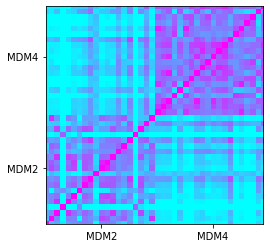

In [22]:
plt.imshow(oasa_heatmap, cmap='cool',vmin=0.80,vmax=1.0)
plt.xticks([10,30],['MDM2','MDM4'],rotation=0)
plt.yticks([10,30],['MDM2','MDM4'])
plt.axis([0,39,0,39])
plt.show()